# Interconnect Project

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

### Evaluation Metrics

Target feature: the `'EndDate'` column equals `'No'`.

Primary metric: AUC-ROC.

Additional metric: Accuracy.

## Contents



## Data Preprocessing

We know that we are aiming to create a predictive model that will determine when a customer is likely to end their service. In order to do this, before we look at the model we can likely guess that our best method to do this will be to create a model that classifies users as having a plan that was cancelled compared to long-standing users and will predict based on their data when a user is likely to cancel.

Before we do that, first we should get a look at our model. It might require extraction from an archived folder if performing on a different machine.

In [1]:
# package imports

# general packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# preprocessing packages

from datetime import datetime
from dateutil import relativedelta
from sklearn.preprocessing import LabelEncoder

# EDA packages

import seaborn as sns

# model training packages

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# model evaluation packages

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

In [2]:
# data frames

contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

First, getting a look at our data to see what we're working with is a good idea.

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Now we can do a check for duplicates.

In [7]:
print("Number of Duplicates:\n",
"Contract:", contract.duplicated().sum(), "\n",
"Personal:", personal.duplicated().sum(), "\n",
"Internet:", internet.duplicated().sum(), "\n",
"Phone:", phone.duplicated().sum())

Number of Duplicates:
 Contract: 0 
 Personal: 0 
 Internet: 0 
 Phone: 0


We do not need to remove any duplicates.

Next, we should check our data frames' info, to look for missing values as well as if our data frame is in the correct format.

Additionally, we will check some of the column values in each of the data frames to see how they might be encoded. The specific practice will be listed per data frame.

In [8]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
# this is to check how many different classifications are in two of the columns, 'Contract' and 'Payment Method'
# it is to see if they might be better to encode

print("Contract:", contract['Type'].unique())
print("Payment Method:", contract['PaymentMethod'].unique())

Contract: ['Month-to-month' 'One year' 'Two year']
Payment Method: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [10]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
# 'Dependents' appears like it might not be a boolean if potentially it has a number of dependents listed

personal['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [13]:
internet['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [14]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


We can identify a few things in this step, that we might want to keep in mind. One thing that we don't need to think much about is how the internet and phone dataframes are smaller while the contract and personal data frames are the same size. This makes sense, as some users would likely only be using one of the two plans.

However, we should make a note of what we likely will want to alter in preprocessing:

* Contract Dataframe

    * BeginDate and EndDate columns are in object format, not datetime
    * PaperlessBilling is an object that could be represented as a boolean integer
    * TotalCharges is not a float object

* Personal Dataframe

    * Gender, Partner, and Dependents are all objects that could be represented as boolean integers

* Internet Dataframe

    * All columns outside of customerID and InternetService could be represented as booleans

* Phone Dataframe

    * MultipleLines could be represented as a boolean
    
Overall, our preprocessing is showing that for our data we can do our preprocessing primarily by altering our data type. We might not need to perform encoding, but if need be we know that it can be performed on all the columns.

### Data Preparation

First, we should fix our data types. There might be a complication in trying to convert TotalCharges to a float but if the data is formatted correctly and it simply had an issue with the importing then it should be simple to convert.

In [15]:
contract['BeginDate'] = contract['BeginDate'].astype('datetime64[ns]')

In [16]:
# this should convert all of our data in the TotalCharges column to a float
# if it results in an error we will know what exactly the string is that is causing an error
# (it might be something like "null" or a typo with a comma instead of a period or the like, a ValueError will show us)

# for i in range(len(contract)):
#    contract['TotalCharges'][i] = [float(x) for x in contract['TotalCharges'][i]]

# because this code is intended to check for what caused the column to be represented as a string
# it will be kept in the notebook, but since it was meant to cause an error it will be turned into a comment
# so the error does not occur when running the notebook from the beginning

From the looks of things, the reason why our TotalCharges column is resulting in it being a float is because we have some values that are blank, with a TotalCharges of ' '. Let's see if this is the case.

In [17]:
contract[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


We can confirm this is the case. It appears that there was an error for the accounts that have a begin date of February 1, 2020. that resulted in their TotalCharges being blank. This makes sense because it is our most recent data in our set, the customers in question have not yet had to make a single payment. Thus, we should fill out these customer's TotalCharges as 0.

But first, we should confirm that these are, in fact, all of the data from February 1.

In [18]:
contract[contract['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [19]:
# this will convert our column to numeric and fill the February 1 values at the same time

contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors = 'coerce').fillna(0)

Now we should use a check on EndDate column. This is a bit more complicated, since EndDate is "No" if the plan was not cancelled and is represented by a date value if the plan has been cancelled. In order to do this, we should instead make two columns, one that clarifies if the plan has been ended and another with the date.

We will create a new feature, LastDate, that records the latest known service date. We will use a datetime of March 1, 2020 for any customer who has not ended their service. While it differs based on their service plan, it will be a more useful metric since anyone who has not cancelled by February 1 will have their service going at least through to March.

In [20]:
end_dates = []
for value in contract.EndDate:
    if value != 'No':
        date_and_time = datetime.strptime(value, '%Y-%m-%d %H:%M:%S')
        end_dates.append(date_and_time)
    else:
        end_dates.append(datetime(2020, 3, 1, 0, 0, 0))

In [21]:
# add LastDate

contract.insert(3, 'LastDate', pd.to_datetime(end_dates))

The reason why we are setting March 1 as our last date is because we We could try and create a more complicated model that accounts for their type of payment plan but that should not be required and could cause issues.

The column we will add is CustomerDuration. This will be found by finding the difference between LastDate and BeginDate and represented numerically, in months. This will give us insight to find out at what point most of our users might stop using the service. It also will let us have access to a column with data related to dates by encoding it for our machine learning models.

In [22]:
# add CustomerDuration

contract.insert(4, 'CustomerDuration', (contract['LastDate'] - contract['BeginDate'])/np.timedelta64(1, 'M'))

In [23]:
contract.head()

,customerID,BeginDate,EndDate,LastDate,CustomerDuration,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,2020-03-01,1.971293,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,2020-03-01,34.990452,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,2019-12-01,2.004148,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,2020-03-01,45.996838,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,2019-11-01,2.004148,Month-to-month,Yes,Electronic check,70.70,151.65


In [24]:
# check that the columns were converted properly

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   LastDate          7043 non-null   datetime64[ns]
 4   CustomerDuration  7043 non-null   float64       
 5   Type              7043 non-null   object        
 6   PaperlessBilling  7043 non-null   object        
 7   PaymentMethod     7043 non-null   object        
 8   MonthlyCharges    7043 non-null   float64       
 9   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(3), object(5)
memory usage: 550.4+ KB


Our "contract" data frame has been converted successfully.

We will also add a clear, boolean target column. We will call this ServiceEnded, set as 0 if the user did not end their service or 1 if they have.

In [25]:
# add column showing if contract has been ended

contract['ServiceEnded'] = (contract['EndDate'] != 'No').astype('int')

In [26]:
contract.head()

,customerID,BeginDate,EndDate,LastDate,CustomerDuration,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ServiceEnded
0,7590-VHVEG,2020-01-01,No,2020-03-01,1.971293,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,2020-03-01,34.990452,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,2019-12-01,2.004148,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,2020-03-01,45.996838,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,2019-11-01,2.004148,Month-to-month,Yes,Electronic check,70.70,151.65,1


All of our other possible data prepreparation involves encoding which we may or may not find useful. From this point, it will be useful to create a single unified data frame with our four. We want to perform a left merge, using customerID as the column to merge on.

Because "contract" has 10 columns, "personal" has 5, "internet" has 8, and "phone" has 2, then combining them all on a single column should result in a data frame with 22 columns.

In [27]:
data = (contract.merge(
    personal, how = 'left', on = 'customerID').merge(
    internet, how = 'left', on = 'customerID').merge(
    phone, how = 'left', on = 'customerID')
       )

In [28]:
data.head()

,customerID,BeginDate,EndDate,LastDate,CustomerDuration,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,2020-03-01,1.971293,Month-to-month,Yes,Electronic check,29.85,29.85,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,2020-03-01,34.990452,One year,No,Mailed check,56.95,1889.50,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,2019-12-01,2.004148,Month-to-month,Yes,Mailed check,53.85,108.15,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,2020-03-01,45.996838,One year,No,Bank transfer (automatic),42.30,1840.75,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,2019-11-01,2.004148,Month-to-month,Yes,Electronic check,70.70,151.65,...,No,No,Fiber optic,No,No,No,No,No,No,No


### Preparing Full Data Set

Since we have created a new data set from our previous ones using a left join, it likely will have some null values that we will need to fill.

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   LastDate          7043 non-null   datetime64[ns]
 4   CustomerDuration  7043 non-null   float64       
 5   Type              7043 non-null   object        
 6   PaperlessBilling  7043 non-null   object        
 7   PaymentMethod     7043 non-null   object        
 8   MonthlyCharges    7043 non-null   float64       
 9   TotalCharges      7043 non-null   float64       
 10  ServiceEnded      7043 non-null   int64         
 11  gender            7043 non-null   object        
 12  SeniorCitizen     7043 non-null   int64         
 13  Partner           7043 non-null   object        
 14  Dependents        7043 n

We can see here clearly that the following columns have null objects: InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLine. This makes sense, these are the ones for our smaller data sets. Fortunately, these are all at least at present represented by objects and generally are all either "Yes" or "No".

We should set those columns that are all either "yes" or "no" with "no" values. This will leave the "InternetService" column which we could just fill with "No" the same as the others or we could use "None". For the sake of simplicity, we will use "No" for all of the fills.

In [30]:
no_columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
              'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

for col in no_columns:
    data[col] = data[col].fillna('No')

In [31]:
# check to ensure all data is present

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   LastDate          7043 non-null   datetime64[ns]
 4   CustomerDuration  7043 non-null   float64       
 5   Type              7043 non-null   object        
 6   PaperlessBilling  7043 non-null   object        
 7   PaymentMethod     7043 non-null   object        
 8   MonthlyCharges    7043 non-null   float64       
 9   TotalCharges      7043 non-null   float64       
 10  ServiceEnded      7043 non-null   int64         
 11  gender            7043 non-null   object        
 12  SeniorCitizen     7043 non-null   int64         
 13  Partner           7043 non-null   object        
 14  Dependents        7043 n

We also might find it useful to add a couple of columns that tell us numerically details about their plans. We will call this column NetServices.

We will find this by taking 7 minus the number of "No" inputs in the 7 columns we imported from the "Internet" data frame. The reason for this is because we could count the services alone, but also including the InternetService column lets us convey that NetServices = 0 means that the user is not using any internet service and NetServices = 1 conveys that they are not using security, streaming, etc. services.

In [32]:
data['NetServices'] = [7-x.count('No') for x in zip(data['InternetService'],
                                                    data['OnlineSecurity'],
                                                    data['OnlineBackup'],
                                                    data['DeviceProtection'],
                                                    data['TechSupport'], 
                                                    data['StreamingTV'], 
                                                    data['StreamingMovies'])]

In [33]:
data.head()

,customerID,BeginDate,EndDate,LastDate,CustomerDuration,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,NetServices
0,7590-VHVEG,2020-01-01,No,2020-03-01,1.971293,Month-to-month,Yes,Electronic check,29.85,29.85,...,No,DSL,No,Yes,No,No,No,No,No,2
1,5575-GNVDE,2017-04-01,No,2020-03-01,34.990452,One year,No,Mailed check,56.95,1889.50,...,No,DSL,Yes,No,Yes,No,No,No,No,3
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,2019-12-01,2.004148,Month-to-month,Yes,Mailed check,53.85,108.15,...,No,DSL,Yes,Yes,No,No,No,No,No,3
3,7795-CFOCW,2016-05-01,No,2020-03-01,45.996838,One year,No,Bank transfer (automatic),42.30,1840.75,...,No,DSL,Yes,No,Yes,Yes,No,No,No,4
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,2019-11-01,2.004148,Month-to-month,Yes,Electronic check,70.70,151.65,...,No,Fiber optic,No,No,No,No,No,No,No,1


Lastly, before we perform EDA we will be able to get better EDA if we encode our booleans now.

We will take 11 columns as stated before and convert them into booleans. For 10 of them, 'PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', and 'MultipleLines', we can map them onto "Yes" and "No" and the last one is "Gender" which we can map a boolean onto "Male" and "Female".

We might wish to encode the 'Type', 'PaymentMethod' and 'InternetService' columns but for EDA it could be useful to have them remain as categorical for the moment.

In [34]:
# set boolean columns

bool_cols = ['PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 
             'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

# convert to boolean

for columns in bool_cols:
    data[columns] = data[columns].map({'Yes' : 1 ,'No' : 0})

# convert gender to boolean
data['gender'] = data['gender'].map({'Male' : 1 ,'Female' : 0})

In [35]:
# one final check to ensure everything looks fine

data.head()

,customerID,BeginDate,EndDate,LastDate,CustomerDuration,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,NetServices
0,7590-VHVEG,2020-01-01,No,2020-03-01,1.971293,Month-to-month,1,Electronic check,29.85,29.85,...,0,DSL,0,1,0,0,0,0,0,2
1,5575-GNVDE,2017-04-01,No,2020-03-01,34.990452,One year,0,Mailed check,56.95,1889.50,...,0,DSL,1,0,1,0,0,0,0,3
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,2019-12-01,2.004148,Month-to-month,1,Mailed check,53.85,108.15,...,0,DSL,1,1,0,0,0,0,0,3
3,7795-CFOCW,2016-05-01,No,2020-03-01,45.996838,One year,0,Bank transfer (automatic),42.30,1840.75,...,0,DSL,1,0,1,1,0,0,0,4
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,2019-11-01,2.004148,Month-to-month,1,Electronic check,70.70,151.65,...,0,Fiber optic,0,0,0,0,0,0,0,1


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   LastDate          7043 non-null   datetime64[ns]
 4   CustomerDuration  7043 non-null   float64       
 5   Type              7043 non-null   object        
 6   PaperlessBilling  7043 non-null   int64         
 7   PaymentMethod     7043 non-null   object        
 8   MonthlyCharges    7043 non-null   float64       
 9   TotalCharges      7043 non-null   float64       
 10  ServiceEnded      7043 non-null   int64         
 11  gender            7043 non-null   int64         
 12  SeniorCitizen     7043 non-null   int64         
 13  Partner           7043 non-null   int64         
 14  Dependents        7043 n

## Exploratory Data Analysis

First, we can get a good handle on our data by visualizing it. Most of our visualization will be dealing with the charges since those are our numerical values. We will create a histogram, a box plot, and a correlation matrix. We then will check for class imbalance.

First, we can look at our descriptive statistics. This might not give us perfect insight but it will let us have context to use in other analysis.

Most of our data points have been converted to booleans which will make it harder to read, we will focus primarily on our charges and the amount of services being used.

In [37]:
data[['MonthlyCharges', 'TotalCharges', 'ServiceEnded', 'CustomerDuration', 'NetServices']].describe()

,MonthlyCharges,TotalCharges,ServiceEnded,CustomerDuration,NetServices
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.265370,33.094739,2.821241
std,30.090047,2266.794470,0.441561,24.713423,2.113505
min,18.250000,0.000000,0.000000,0.952792,0.000000
25%,35.500000,398.550000,0.000000,9.002238,1.000000
50%,70.350000,1394.550000,0.000000,29.963654,3.000000
75%,89.850000,3786.600000,1.000000,56.017577,4.000000
max,118.750000,8684.800000,1.000000,72.937843,7.000000


From the looks of things our monthly/total charges are both erratic, which we might expect since they vary based both on the plan and the the length of a service. We should expect TotalCharges to have high variation but generally clustered around the lower end with more outliers impacting the mean since the highest values require many years of service usage.

Most of our customers appear to have a CustomerDuration of around 30 or so, or approximately 2.5 years. However, the standard deviation of this metric is very high so we would expect to see 68% of our users to have a duration between 5 and 57 months (approx 0.5-4.75 years). We can get a good idea of what this will mean by finding a histogram.

Most of the people in the data set have not ended their services as we see that the median and mean both are showing a 0 value.

On average we can conclude that the average customer is using 3 internet services since that is the mean, and the median is 2.82.

### Histograms

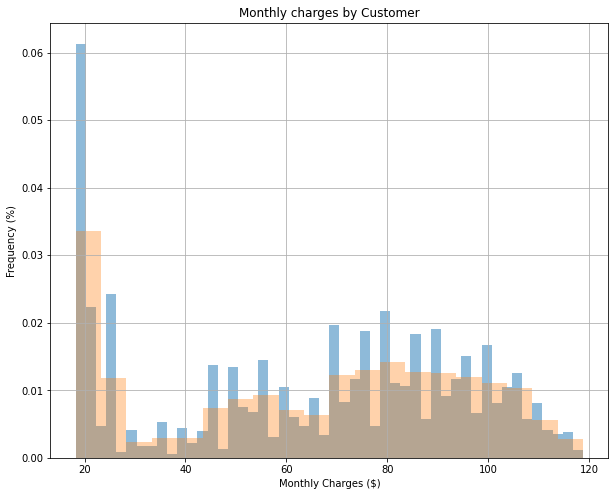

In [38]:
# histogram

fig = plt.figure(figsize = (10,8))

data['MonthlyCharges'].plot(kind = 'hist', bins = 50,
                            density = True, alpha = 0.5)
data['MonthlyCharges'].plot(kind = 'hist', bins = 20, 
                            density = True, alpha = 0.35, grid = True)

plt.title('Monthly charges by Customer')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Frequency (%)');

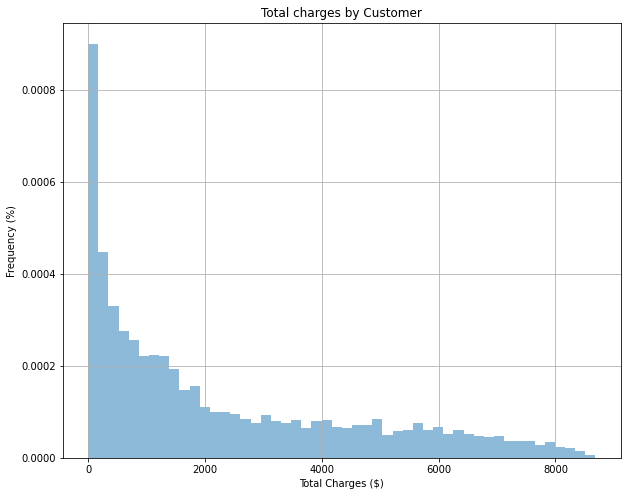

In [39]:
data['TotalCharges'].plot(kind = 'hist', bins = 50,
                          density = True, alpha = 0.5, grid = True, figsize = (10,8))
plt.title('Total charges by Customer')
plt.xlabel('Total Charges ($)')
plt.ylabel('Frequency (%)');

As we might suspect, the monthly charges are fairly scattered. However, there is an overlay with fewer bins that shows a pattern emerge. Most of our users are using a plan that minimizes the cost, but of those who do not they seem to form an approximate normal distribution around an average monthly fee of about \\$80.

It is also possible that there are three groups, with one aiming for minimal costs, one averaging about \\$50 and one averaging at \\$80 - it is unclear if the dip around \\$60 is occurring randomly or if it is part of a pattern. Either way, this idea of different groups with different averages does align with the numbers we see in our descriptive statistics.

The histogram for the total charges is far more clear in the meaning. We see most observations at lower total charges and then it declines. This is not any surprise, nor is it any cause for concern, it simply means that most of our users are not long-time subscribers. For reference, if a user is paying an \\$80 monthly fee, it would take them a little over 4 years to reach a total charge of \\$4000.

One thing that we might learn from our total charges histogram is that since it appears that the decline in frequency slows after a point that users who have been using the service for a given amount of time will both be less likely to stop using the service and will probably not be upgrading or downgrading their services. This might be why we see roughly the same proportion of users with a total charge of \\$2000, \\$4000 and \\$6000.

Finally, we will create a histogram of our observed customer duration. Since our maximum duration is 72, we can set 12 bins which will separate our data into approximate segments of 6 months.

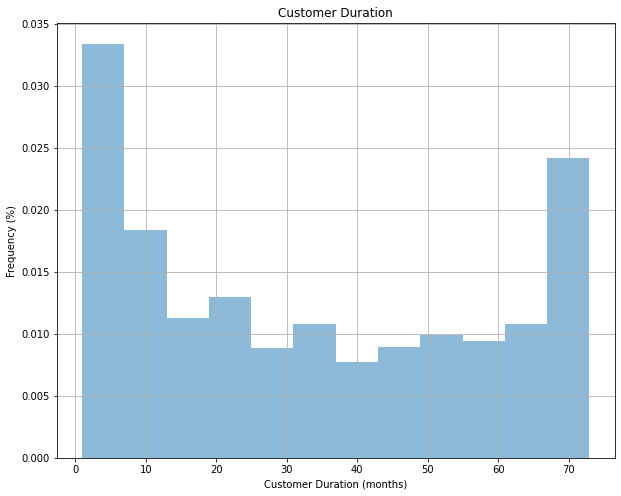

In [40]:
fig = plt.figure(figsize = (10,8))

data['CustomerDuration'].plot(kind = 'hist', bins = 12,
                            density = True, alpha = 0.5, grid = True)
plt.title('Customer Duration')
plt.xlabel('Customer Duration (months)')
plt.ylabel('Frequency (%)');

We see here that most of our customers are leaving within the first 6 months of service and from that point forward they seem to remain fairly consistent. Likely we can conclude that if we hold a customer for at least six months to one year, they will retain services with us.

### Box Plot

First, we will look at the charges as a whole.

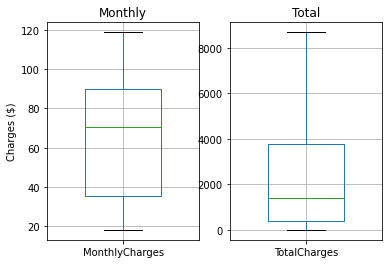

In [41]:
plt.subplot(1, 2, 1)
data.boxplot(column = 'MonthlyCharges', figsize = (5, 5), widths = 0.5)
plt.title('Monthly')
plt.ylabel('Charges ($)')

plt.subplot(1, 2, 2)
data.boxplot(column = 'TotalCharges', figsize = (5, 5), widths = 0.5)
plt.title('Total');

These box plots are visualizations of our descriptive statistics.  They do not tell us anything that we have not already seen up to this point. The main reason we might wish to make a box plot for these numbers specifically is to check for outliers.

We do not see any outliers, which is useful to know. Next, we might get good information if we make some more box plots after grouping the data. The groupings that will provide the best insight will be grouping by their payment plan and by their number of internet services. 

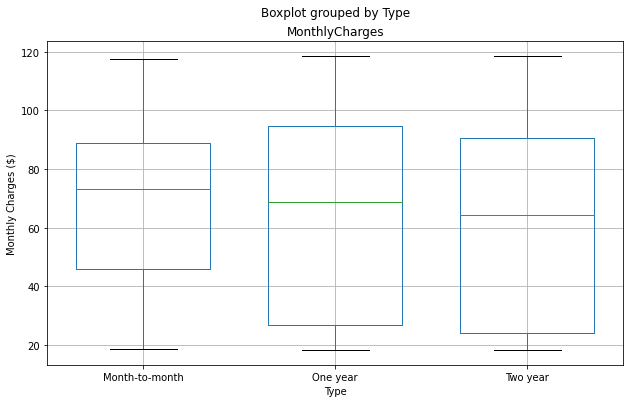

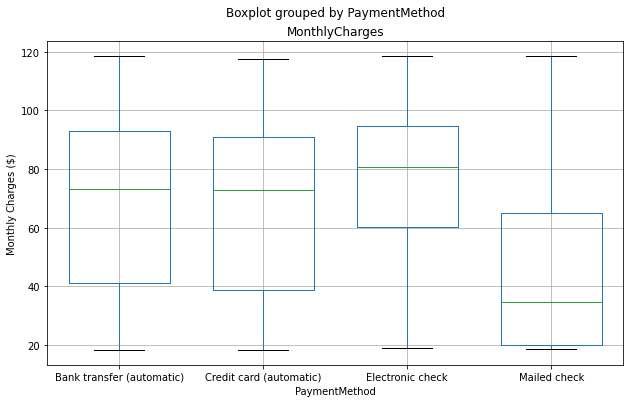

In [42]:
data.boxplot(column = 'MonthlyCharges', by = 'Type', figsize = (10,6), widths = 0.7)
plt.ylabel('Monthly Charges ($)')

data.boxplot(column = 'MonthlyCharges', by = 'PaymentMethod', figsize = (10,6), widths = 0.7)
plt.ylabel('Monthly Charges ($)');

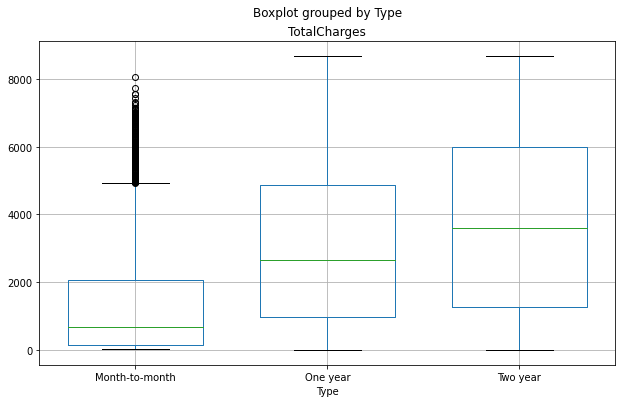

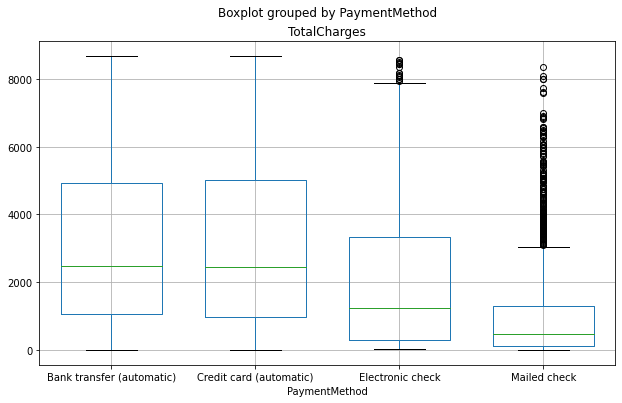

In [43]:
data.boxplot(column = 'TotalCharges', by = 'Type', figsize = (10,6), widths = 0.7)
data.boxplot(column = 'TotalCharges', by = 'PaymentMethod', figsize = (10,6), widths = 0.7);


We see that for the monthly charges the amounts are fairly similar, the month-to-month plans have more condensed numbers but overall they have similar means, minimums and maximums. Obviously this would be because there is a hard cap on the number of plan options, but it also means that users' choices of the type of services they take is not impacted by their payment plan.

What is, however, is their total charges. At least, when it comes to the month-to-month payment. They have a clearly lower overall payment with many outliers. What this seems to suggest is that there are many customers who take a month-to-month contract option and cancel it fairly quickly, but also many who continue to use the services without switching payment models.

A similar concept is conveyed in the box plots grouped by payment method, with checks (both mailed and electronic but moreso mailed) showing the same patterns as the month-to-month payments.

Finally, we can make box plots that group based on the number of internet services used.

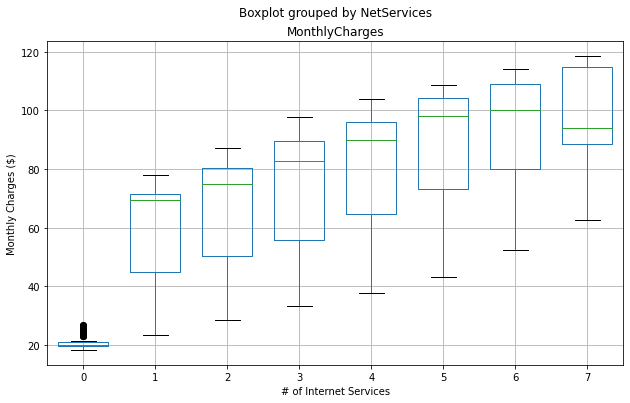

In [44]:
data.boxplot(column = 'MonthlyCharges', by = 'NetServices', figsize = (10,6), widths = 0.7)
plt.xlabel('# of Internet Services')
plt.ylabel('Monthly Charges ($)');

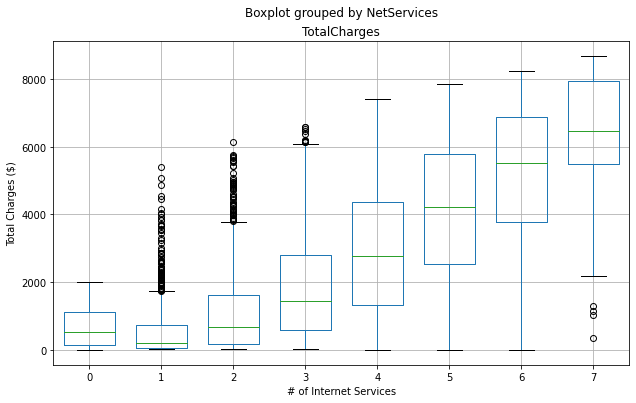

In [45]:
data.boxplot(column = 'TotalCharges', by = 'NetServices', figsize = (10,6), widths = 0.7)
plt.xlabel('# of Internet Services')
plt.ylabel('Total Charges ($)');

Our box plots show that for both monthly and total charges there is a steady increase in the fees. This is one of the strongest connections we can see in the box plots so this is definitely a feature to keep in mind when building our models. On the subject of features, though, we can directly examine our pairs.

### Correlation Matrix

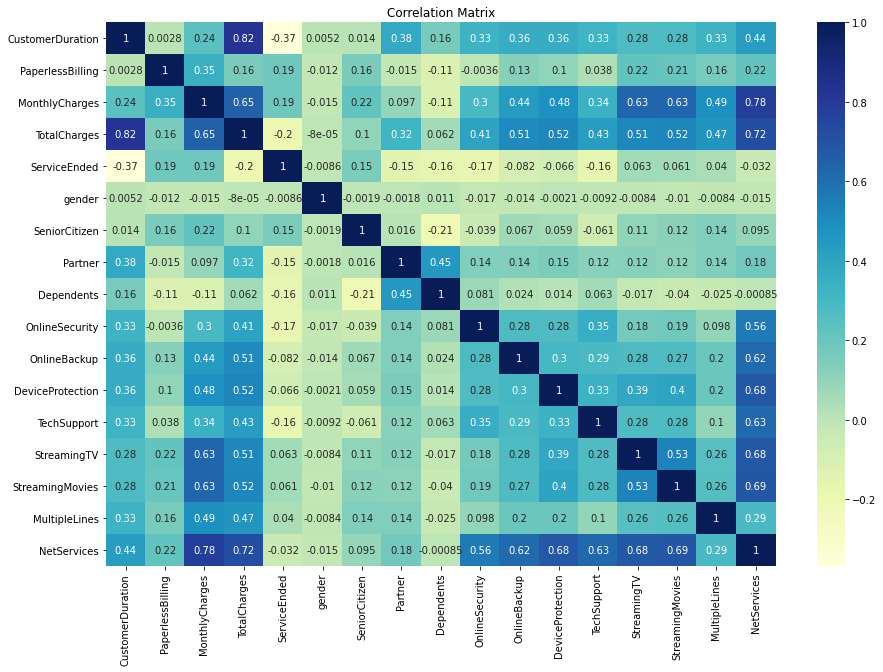

In [46]:
plt.figure(figsize = (15, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot = True, cmap = 'YlGnBu')
plt.title('Correlation Matrix')
plt.show();

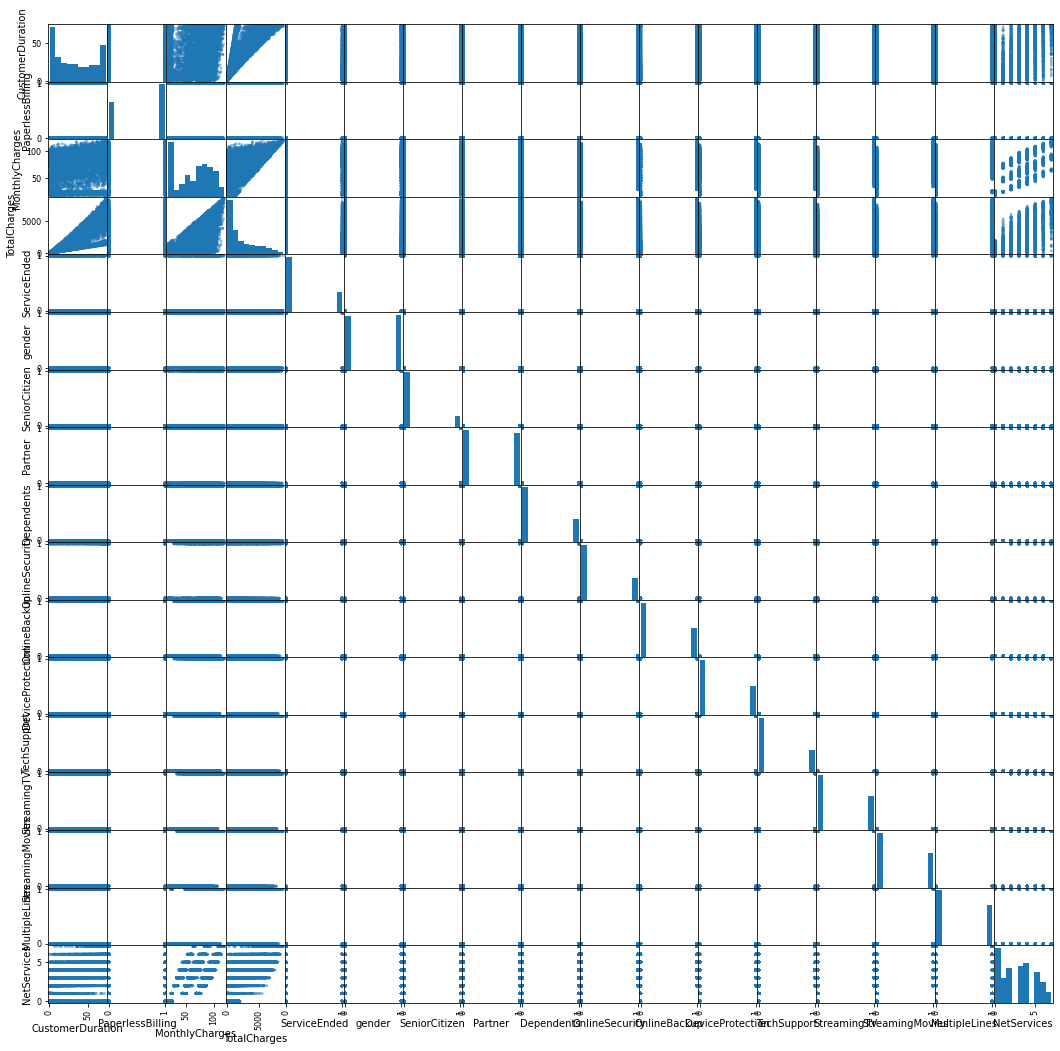

In [47]:
pd.plotting.scatter_matrix(data, figsize=(18, 18))
plt.show()

There are some weak correlations between some of our data points but most of them are rather obvious. For instance, there is a moderately strong (about 0.4 to 0.6) correlation between a specific internet service and the monthly/total fees as well as a strong correlation between someone being married and having dependents but for the most part it does not appear that our data is strongly correlated against other data points.

Ultimately it appears that the strongest correlations that influence our targets are the ones related to price and the services being used. To summarize some of the insights from the correlation matrix in reference to our target ServiceEnded:

* The largest positive correlation to service being ended is the monthly price.
* A similarly strong correlation is found if someone is using paperless billing. This might seem a bit odd, a convenient style of payment done online seems like it should make it easier to retain customers. Is there perhaps an issue with our website? Or perhaps it is simply that there is a correlation showing that customers using paperless billing are more likely to have a higher monthly fee? Something to look into.
* Senior citizens have a moderate correlation with ending their services. This could be unavoidable and the result of seniors being in their winter years. Though it is possibly something worth thinking about.
* There is a negative correlation between total charges and ServiceEnded. This suggests customer retention is overall good.
* Married clients as well as those with dependents have a moderately good negative correlation, they are less likely to cancel their services.
* Security services have a negative correlation with ServiceEnded and particularly the malicious website blocker. This suggests that our products are doing well with their security systems.
* There also is a negative correlation with Tech Support and ServiceEnded, so our tech department seems to be working well.
* On the other hand, it is very slight but there is a small positive correlation between our streaming services and a ServiceEnded = 1. This suggests that perhaps there is something we could improve there.

### Check Class Imbalance

We need to check our class imbalance for the target variable, ServiceEnded. We should expect most of the data set to be 0, meaning customers still using our services. If the dataset is sufficiently imbalanced we might need to account for it.


ServiceEnded value counts:
0    5174
1    1869
Name: ServiceEnded, dtype: int64 

Proportion of data set with ServiceEnded = 1:
 0.2653698707936959 



/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


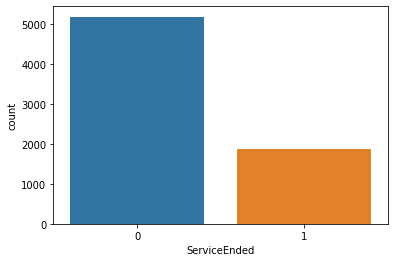

In [48]:
print("ServiceEnded value counts:")
print(data['ServiceEnded'].value_counts(), "\n")
print("Proportion of data set with ServiceEnded = 1:\n", len(data[data['ServiceEnded'] == 1]) / len(data), "\n")
sns.countplot(data['ServiceEnded']);

Roughly 26.5369% of the data is in ServiceEnded = 1. This is probably not horribly balanced but it is not well-balanced. Because the purpose of the model will be to retain customers by determining when one is likely to cancel their plans, accounting for this imbalance after we create our training dataset is probably the better option. It might result in a model more biased towards false positives, but for our intended model, having a false positive is preferable to potentially losing a customer.

## Train the Model

* The project can be completed using a supervised learning model
    * Before we begin training, we should do both a features/target split (our target is the 'EndDate' column)
    * We also will want to split our data for testing purposes
        * We will do a 60/20/20 split with 60% of the data as a training set, 20% as a validation set, and 20% as the test set
* Based on our outline, we will want an AUC-ROC of at least 0.75, but that is the bare minimum
    * We should try to get as high as possible, but will not expect to be able to improve much beyond 0.88
* To get an idea of the time it might take processing the hyperparameter tuning, we should choose some different models
    * Dummy model
    * Decision Tree
    * Linear Regression
    * Random Forest
    * CatBoost
    * Light GBM and XGBoost would also be good to test, but since gradient boosting models take longer to train we will determine that this will only be considered worth trying if the other models are performing poorly

First, we should make a simple function that will give us all the details we might want out of our model evaluation metrics. We will print ROC-AUC, accuracy, F1 score, and a precision-recall score. We will print graphs for these.

Also, we will print a confusion matrix which will tell us if our errors are being caused more by false negatives or false positives.

In [76]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    print()
    
    print('Confusion Matrix')
    print(confusion_matrix(target, pred_target))    
    
    # add a flag that will automatically bring up if our ROC-AUC is too low
    
    print()
    
    if roc_auc < 0.75:
        print("Insufficient ROC-AUC.")
    
    return

### Train/Test Split

First, we split into features and target. Then, we will create three groups for training, validation, and testing. We will use 20% of our data as a test set and then split the remaining values by 25%, leaving 60% of our data as a training set, 20% of the data as a validation set, and the remaining 20% to be used as a test set.

We will also need to alter or drop a few columns. CustomerID will be removed as it cannot and should not be used as a predictive feature. The dates associated with an account will also be removed.

We possess 'Type', 'PaymentMethod', and 'InternetService' as categorical columns that we will want to encode, so we will do that before splitting our data.

In [77]:
# create features and target

features = data.drop(['customerID', 'BeginDate', 'EndDate', 'LastDate', 'ServiceEnded'], axis = 1)
target = data['ServiceEnded']

In [78]:
# encode categorical features

encoders = {}
for column_name in ['Type', 'PaymentMethod', 'InternetService']:
    encoders[column_name] = LabelEncoder()
    features[column_name] = encoders[column_name].fit_transform(features[column_name])

In [79]:
# training/validation/test split

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.20, 
                                                                              random_state = 12345)

features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, 
    test_size = 0.25, random_state = 12345) 

In [80]:
# print the shape to confirm split has been done properly

print("Shapes of the Data Splits:\n")
print("Training:", features_train.shape, target_train.shape)
print("Validation:", features_valid.shape, target_valid.shape)
print("Test:", features_test.shape, target_test.shape)

Shapes of the Data Splits:

Training: (4225, 19) (4225,)
Validation: (1409, 19) (1409,)
Test: (1409, 19) (1409,)


We might wish to confirm once again if the classes are imbalanced, since we can adjust for that now that we have split our training data. We probably will want to upsample our data, for reasons outlined in section 2.4 Check Class Imbalance. We will want to upsample a small amount since it will influence our model.

ServiceEnded value counts:
0    3088
1    1137
Name: ServiceEnded, dtype: int64 



/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


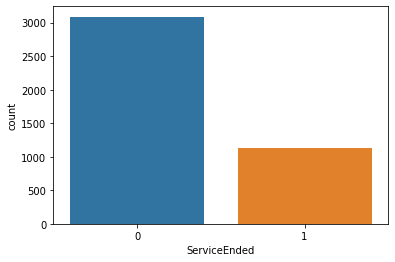

In [81]:
print("ServiceEnded value counts:")
print(target_train.value_counts(), "\n")
sns.countplot(target_train);

In [82]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 2
)

ServiceEnded value counts:
0    3088
1    2274
Name: ServiceEnded, dtype: int64 



/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


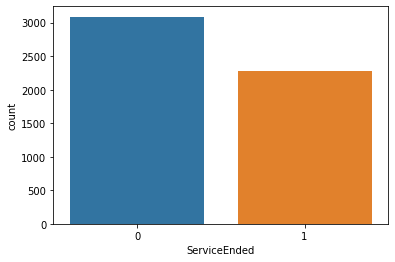

In [83]:
print("ServiceEnded value counts:")
print(target_upsampled.value_counts(), "\n")
sns.countplot(target_upsampled);

We will not use the upsampled data for the moment, but will keep it as an option if our initial models are not promising.

### Dummy Model

First, we will create a dummy model. We should expect accuracy metrics of around 50% at best, but it will be good to benchmark. It also will let us test our evaluate_model function.

In [84]:
# create model

dummy_model = DummyClassifier(strategy = 'uniform')
dummy_model.fit(features_train, target_train)

DummyClassifier(strategy='uniform')

          train  test
Accuracy   0.52  0.51
F1         0.36  0.35
APS        0.27  0.25
ROC AUC    0.50  0.50

Confusion Matrix
[[534 522]
 [169 184]]

Insufficient ROC-AUC.


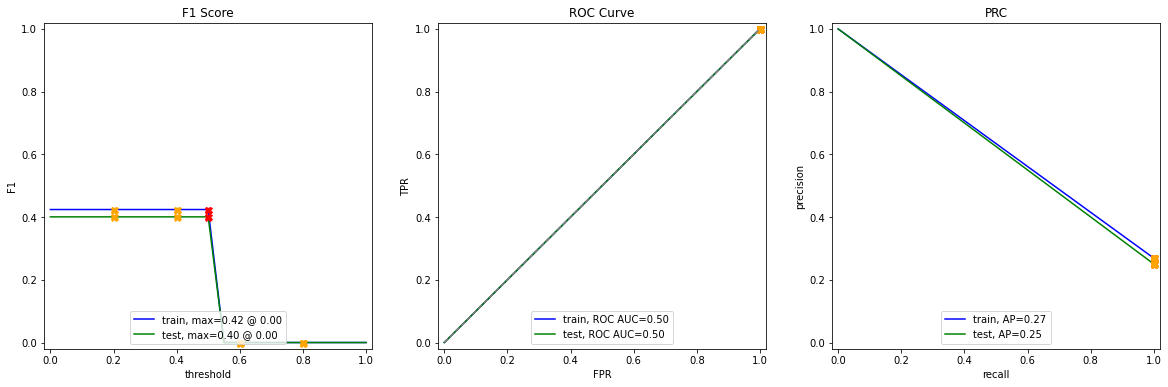

In [85]:
# test model

evaluate_model(dummy_model, features_train, target_train, features_valid, target_valid)

### Try Basic Models

Before we progress further, we can check to see what our models look like with default parameters and without using the upsampled data. We also will keep an eye on the time it takes for the computer to train them.

In [86]:
%time

# decision tree

dt = DecisionTreeClassifier(random_state = 12345)
dt.fit(features_train, target_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


DecisionTreeClassifier(random_state=12345)

          train  test
Accuracy    1.0  0.84
F1          1.0  0.69
APS         1.0  0.55
ROC AUC     1.0  0.79

Confusion Matrix
[[940 116]
 [106 247]]



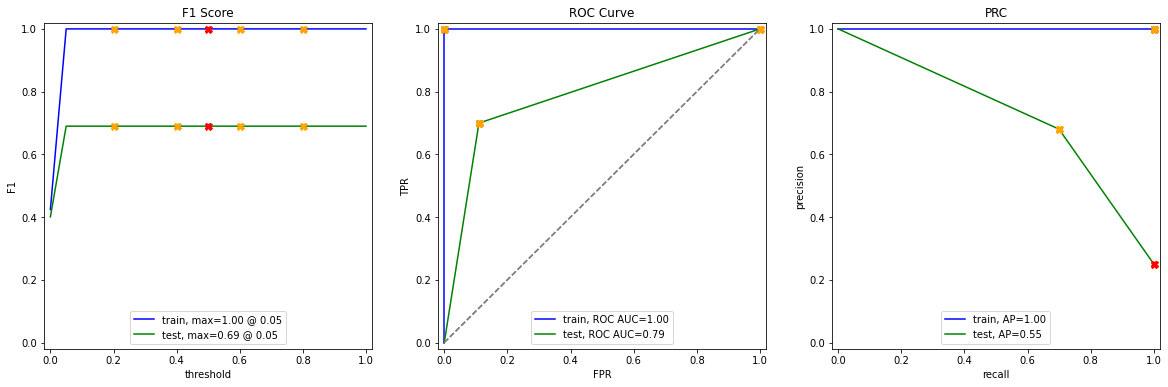

In [87]:
evaluate_model(dt, features_train, target_train, features_valid, target_valid)

In [88]:
%time
# logistic regression

lr = LogisticRegression(random_state = 12345, solver = 'liblinear')
lr.fit(features_train, target_train)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.81  0.81
F1         0.63  0.60
APS        0.70  0.65
ROC AUC    0.86  0.84

Confusion Matrix
[[935 121]
 [151 202]]



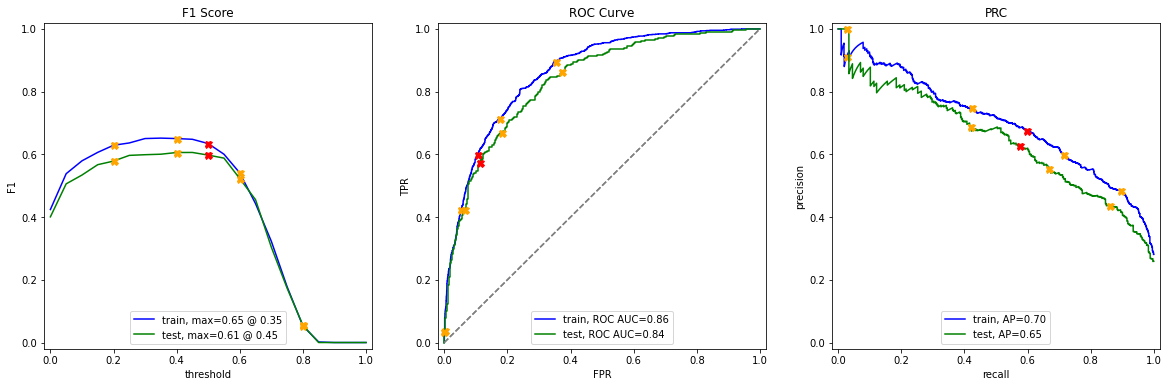

In [89]:
evaluate_model(lr, features_train, target_train, features_valid, target_valid)

In [90]:
%time

# random forest

rf = RandomForestClassifier(random_state = 12345)
rf.fit(features_train, target_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


RandomForestClassifier(random_state=12345)

          train  test
Accuracy    1.0  0.83
F1          1.0  0.62
APS         1.0  0.73
ROC AUC     1.0  0.86

Confusion Matrix
[[981  75]
 [160 193]]



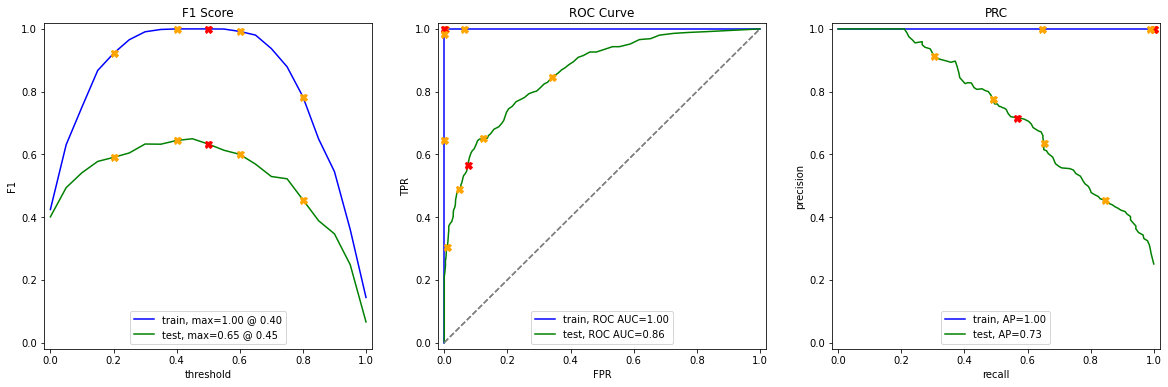

In [91]:
evaluate_model(rf, features_train, target_train, features_valid, target_valid)

In [92]:
%time

# catboost

cb = CatBoostClassifier()
cb.fit(features_train, target_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs
Learning rate set to 0.019062
0:	learn: 0.6782802	total: 2.27ms	remaining: 2.26s
1:	learn: 0.6631803	total: 4.29ms	remaining: 2.14s
2:	learn: 0.6487739	total: 6.37ms	remaining: 2.12s
3:	learn: 0.6341305	total: 8.3ms	remaining: 2.07s
4:	learn: 0.6207833	total: 10.3ms	remaining: 2.06s
5:	learn: 0.6101496	total: 12.2ms	remaining: 2.02s
6:	learn: 0.5982881	total: 14ms	remaining: 1.99s
7:	learn: 0.5893430	total: 15.9ms	remaining: 1.97s
8:	learn: 0.5801134	total: 17.9ms	remaining: 1.97s
9:	learn: 0.5699825	total: 19.9ms	remaining: 1.97s
10:	learn: 0.5600663	total: 21.9ms	remaining: 1.97s
11:	learn: 0.5511663	total: 24.5ms	remaining: 2.01s
12:	learn: 0.5437119	total: 27.3ms	remaining: 2.07s
13:	learn: 0.5359809	total: 29.9ms	remaining: 2.11s
14:	learn: 0.5282790	total: 32.6ms	remaining: 2.14s
15:	learn: 0.5219896	total: 35.3ms	remaining: 2.17s
16:	learn: 0.5160072	total: 38.3ms	remaining: 2.22s
17:	learn: 0.5099147	total: 40.4ms	

          train  test
Accuracy   0.95  0.91
F1         0.90  0.79
APS        0.98  0.89
ROC AUC    0.99  0.94

Confusion Matrix
[[1028   28]
 [ 104  249]]



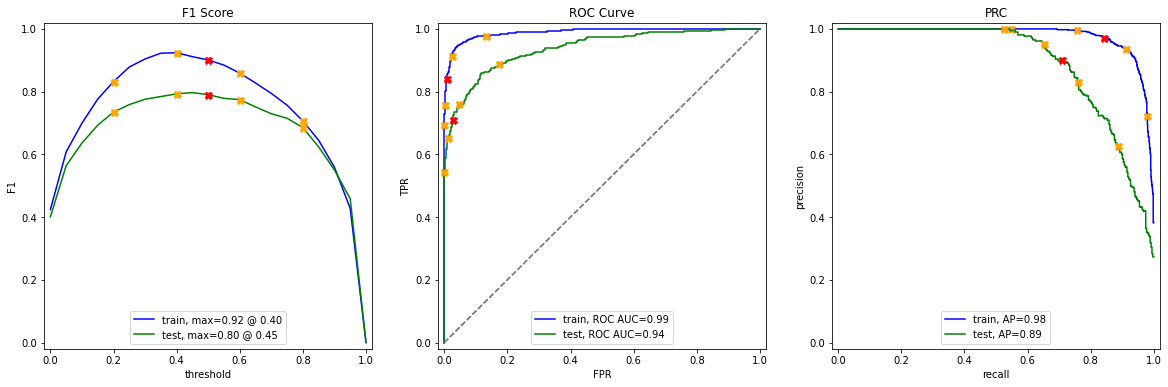

In [93]:
evaluate_model(cb, features_train, target_train, features_valid, target_valid)

Even without performing gridsearch or using our upsampling, we find a very strong set of models here. Our best set is catboost. At present, we do not have any significant difference in compilation time.

### Try Upsampled Models

In [94]:
%time

# decision tree

dt2 = DecisionTreeClassifier(random_state = 12345)
dt2.fit(features_upsampled, target_upsampled)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


DecisionTreeClassifier(random_state=12345)

          train  test
Accuracy    1.0  0.80
F1          1.0  0.63
APS         1.0  0.48
ROC AUC     1.0  0.76

Confusion Matrix
[[891 165]
 [114 239]]



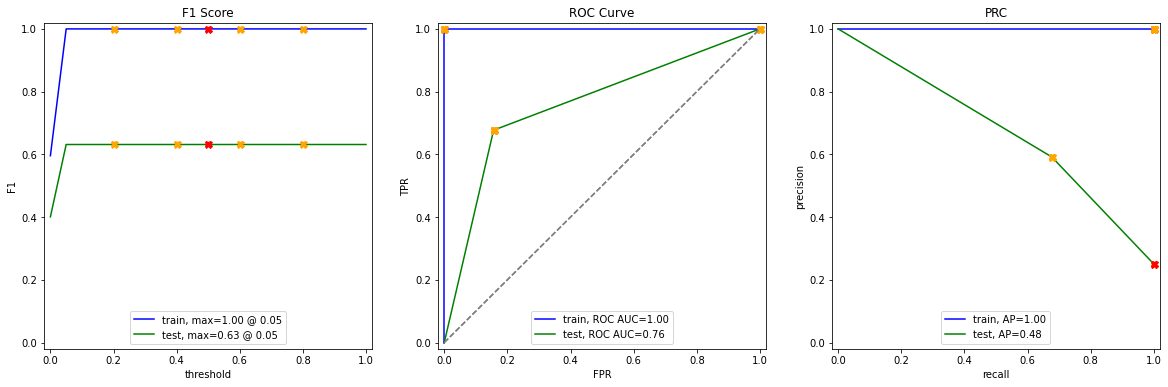

In [95]:
evaluate_model(dt2, features_upsampled, target_upsampled, features_valid, target_valid)

In [96]:
%time
# logistic regression

lr2 = LogisticRegression(random_state = 12345, solver = 'liblinear')
lr2.fit(features_upsampled, target_upsampled)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.77  0.75
F1         0.74  0.60
APS        0.81  0.64
ROC AUC    0.86  0.83

Confusion Matrix
[[803 253]
 [ 95 258]]



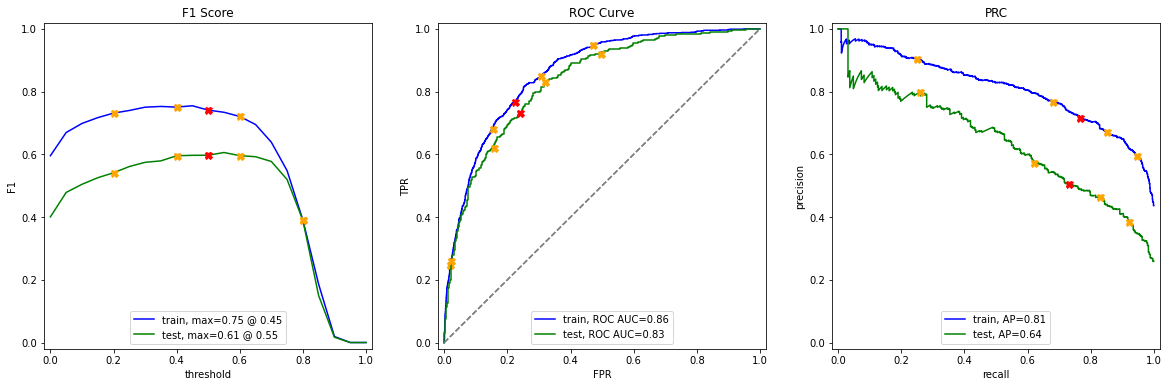

In [97]:
evaluate_model(lr2, features_upsampled, target_upsampled, features_valid, target_valid)

In [98]:
%time

# random forest

rf2 = RandomForestClassifier(random_state = 12345)
rf2.fit(features_upsampled, target_upsampled)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


RandomForestClassifier(random_state=12345)

          train  test
Accuracy    1.0  0.83
F1          1.0  0.65
APS         1.0  0.73
ROC AUC     1.0  0.86

Confusion Matrix
[[947 109]
 [131 222]]



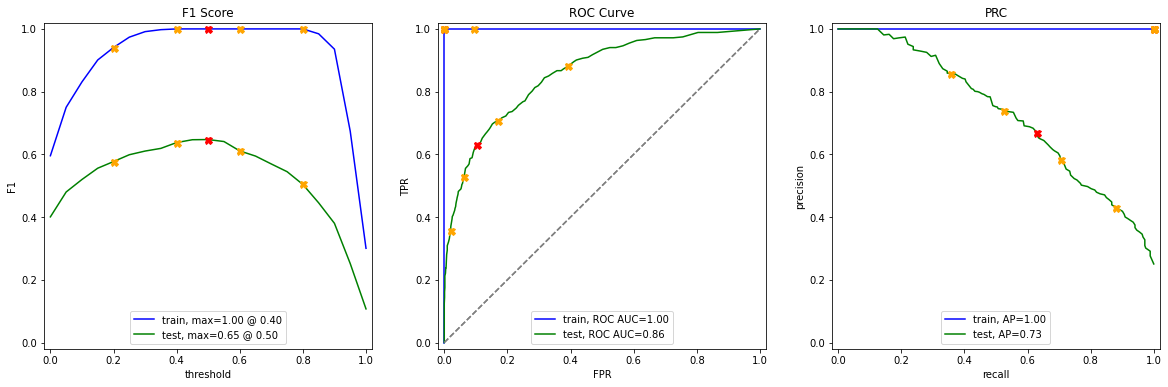

In [99]:
evaluate_model(rf2, features_upsampled, target_upsampled, features_valid, target_valid)

In [100]:
%time

# catboost

cb2 = CatBoostClassifier()
cb2.fit(features_upsampled, target_upsampled)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
Learning rate set to 0.021104
0:	learn: 0.6789944	total: 2.28ms	remaining: 2.27s
1:	learn: 0.6656200	total: 5.01ms	remaining: 2.5s
2:	learn: 0.6524330	total: 7.14ms	remaining: 2.37s
3:	learn: 0.6433687	total: 8.97ms	remaining: 2.23s
4:	learn: 0.6332287	total: 12.1ms	remaining: 2.4s
5:	learn: 0.6239479	total: 14.5ms	remaining: 2.41s
6:	learn: 0.6131322	total: 17ms	remaining: 2.41s
7:	learn: 0.6039181	total: 20.1ms	remaining: 2.49s
8:	learn: 0.5952087	total: 23.7ms	remaining: 2.6s
9:	learn: 0.5883302	total: 26.8ms	remaining: 2.65s
10:	learn: 0.5817280	total: 30.1ms	remaining: 2.7s
11:	learn: 0.5761689	total: 33.2ms	remaining: 2.73s
12:	learn: 0.5683449	total: 36.4ms	remaining: 2.76s
13:	learn: 0.5629474	total: 39.6ms	remaining: 2.79s
14:	learn: 0.5557667	total: 43ms	remaining: 2.82s
15:	learn: 0.5508668	total: 46.2ms	remaining: 2.84s
16:	learn: 0.5444035	total: 49.6ms	remaining: 2.87s
17:	learn: 0.5388601	total: 53ms	remaini

          train  test
Accuracy   0.97  0.91
F1         0.96  0.81
APS        1.00  0.90
ROC AUC    1.00  0.94

Confusion Matrix
[[997  59]
 [ 71 282]]



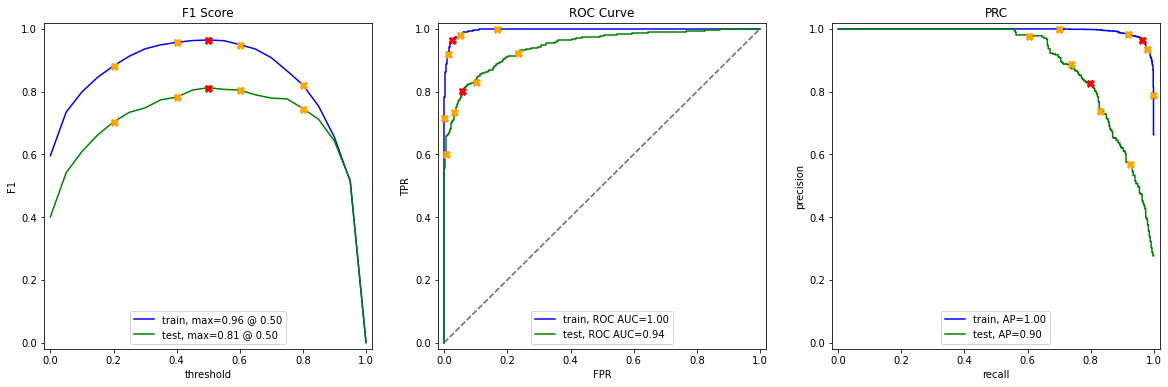

In [101]:
evaluate_model(cb2, features_upsampled, target_upsampled, features_valid, target_valid)

The upsampling did not greatly impact any of our models but overall it resulted in higher accuracy. However, it could be argued that this higher accuracy may be an undesirable result specifically because it balances the false positives and false negatives which results in our Catboost model seeing more false negatives. We have already positioned that false positives are preferable to false negatives for our goals of increasing customer retention.

Ultimately, a gridsearch does not appear to be necessary. It tends to be a lengthy process and our CatBoost model appears to be performing close to maximum accuracy. Thus, we will use CatBoost as our model of choice and proceed to check it against our test set.

## Test the Model

We will test our CatBoost model against the test set. If the metrics do not work that will suggest that our model was overfitted when we built it.

          train  test
Accuracy   0.95  0.91
F1         0.90  0.82
APS        0.98  0.91
ROC AUC    0.99  0.95

Confusion Matrix
[[1009   21]
 [ 103  276]]



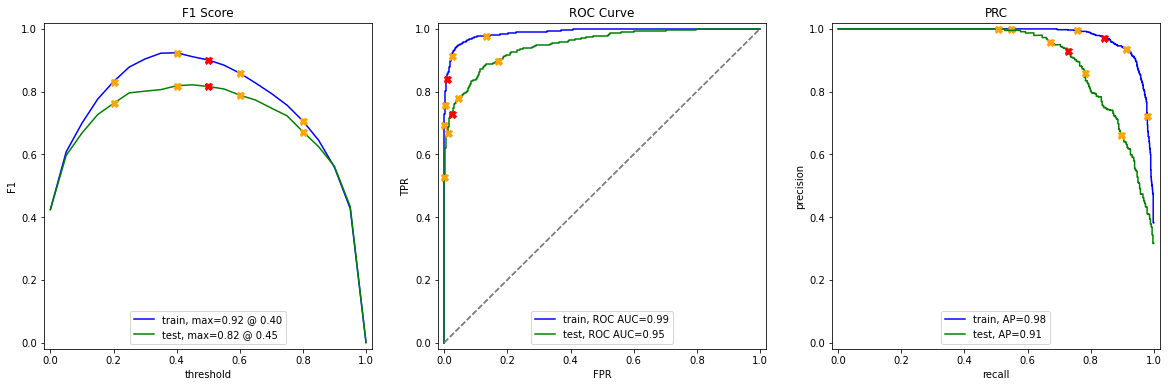

In [102]:
evaluate_model(cb, features_train, target_train, features_test, target_test)

## Conclusions

In our project we aimed to create a predicitive model that will classify when a user is likely to cancel their services. We would determine our model a success based on the ROC-AUC score. A score lower than 0.75 was defined as too low, and an ideal score would be one higher than 0.88. We also wished to measure accuracy.

Since the goal of the model is to retain customers, we determined that we would prioritize a model even if it had slightly lower accuracy if its accuracy was more inclined towards returning a false positive, as a false positive would result in retaining customers with more certainty and a false negative means that we will have lost a customer that we otherwise might have kept.

First, we preprocessed our data to make all of the metrics usable for building our model. To create a full data set, we made a few key changes. We calculated the number of months a customer had been using the service, encoded our binary features, and counted the number of internet services a customer was utilizing. Doing this, we created a unified data set from our four separate data frames.

Afterwards, we performed exploratory data analysis. We created histograms that gave us an idea of customer paying practices as well as our general ability to retain customers. We created box plots to check for outliers across a few different metrics. Then, we created a correlation matrix to see which of our features might be related to a customer continuing to use our service or to stop using it. We also checked our class imbalance to determine if we might wish to correct for imbalanced classes.

To create our models, we created a split with 60% of the data in our training set, 20% in a test set and 20% in a validation set.

We made models across five styles: a dummy model, a decision tree, a logistic regression, a random forest, and a catboost. We first ran tests with no parameter tuning and our original data without accounting for imbalance. There, we created models that met both the standards for ROC-AUC and accuracy. We tried once more with upsampling and while accuracy did slightly rise it tended to be at the cost of returning more false negatives. As stated before, we would prioritize minimalizing false negatives rather than purely aiming for accuracy and so we chose to use our initial models.

Because tuning our hyperparameters is rather time-consuming and we already had achieved a model that was testing with over 0.90 ROC-AUC, we determined that the model was more than sufficient as the one to use.

- [x] The code is error free and arranged in order of execution.
- [x] Documentation is present directly preceding all code explaining its purpose.
- [x] The data has been downloaded and prepared.
- [x] Exploratory data analysis with graphical representation has been performed.
- [x] The models have been trained.
- [x] A final model has been created with an AUC-ROC of at least 0.75

### Solution Report

1. What steps of the plan were performed and what steps were skipped (explain why)?

We followed most the steps of our outline, doing preprocessing, EDA with histograms, box plot, correlation matrix, and class imbalance. We then trained the model across five metrics: dummy, decision tree, logistic regression, random forest, and catboost. We checked against a test set of 20% of our data to confirm our model was functioning.

We skipped hyperparameter tuning because our models were already meeting AUC-ROC and accuracy standards. Hyperparameter tuning, being time consuming and not able to significantly improve our model, was thus deemed unnecessary.

2. What difficulties did you encounter and how did you manage to solve them?

Some of the largest difficulties in the project were within the preprocessing stage, in determining how to manipulate our data frame such that we have as much data available for use in model training. It was a bit tricky to find a way to create the CustomerDuration feature, but looking online for advice on similar issues to reference how to get the data in the correct format was fairly simple.

3. What were some of the key steps to solving the task?

Most likely, the preprocessing was the most important step in solving the task, specifically adding the CustomerDuration feature. As we saw in our EDA step, the CustomerDuration was most strongly correlated with whether or not a user ended their service or not and we identified in our histogram that after 12 months we have approximately a uniform distribution of CustomerDuration, meaning that if we can retain a customer for 6-12 months they are likely to continue using the services.

In terms of how to best utilize the data analysis and the predictive model to shape policy, the correlation matrix seems to have been very useful as it identifies correlations between the bonus internet services and customer retention. It gives us a look at areas that are doing well and ones that might need some improvement.

4. What is your final model and what quality score does it have?

The final model is the catboost classifier model, trained on a subset of 60% of the total data set. It uses default hyperparameters. The ROC-AUC against the test set of 20% of the total data set is 0.95, with an accuracy of 0.91. With that accuracy, we can state that the model has approximately 1.49% false negative reports and 7.31% false positive reports.

What this means is that it only has approximately 1.49% chance of failing to identify when a customer is about to leave and a 7.31% chance of falsely identifying that a customer is about to leave when they are not. For the purposes of benefitting customer retention, the model works very well.